## Standard Imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from polire.placement import NottDuns, Stationary

## Data Loading

In [3]:
tdata = pd.read_pickle('/home/patel_zeel/Krause-NOSP-Replication/Data/TempData.pickle')
tdata = tdata['2004-02-28':'2004-03-01']
loc_df = pd.read_csv('/home/patel_zeel/Krause-NOSP-Replication/Intel Data/mote_locs.txt', sep=' ',names=[0,'X','Y']).set_index(0)
M = 22
cross_df = pd.crosstab(tdata.index, tdata.ID, tdata.Temp, aggfunc=lambda x:list(x)[0])
cross_df = cross_df.resample(str(M)+'min').mean().dropna(how='any')
print(cross_df.shape, len(cross_df.dropna()), cross_df.cov().dropna().shape)

G_all = (((cross_df - cross_df.mean()).T).dot(cross_df - cross_df.mean())/len(cross_df)) # Estim. Cov. Mat.
G_all_npcov = cross_df.cov()
train_data = loc_df.loc[cross_df.columns][['X','Y']]
train_data['Temp'] = cross_df.mean()

(181, 52) 181 (52, 52)


## Destroying ID to maintain consistency between pandas and numpy

In [4]:
train_data = train_data.reset_index(drop=True)
G_all = pd.DataFrame(G_all.values, index=range(len(train_data)), columns=range(len(train_data)))

## Visualize all sensor locations in the 2D space

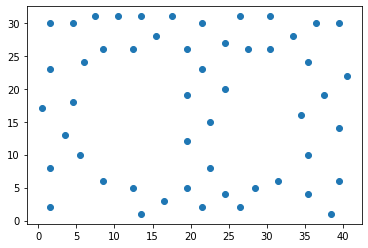

In [5]:
plt.scatter(train_data['X'], train_data['Y'])

## Visualize train sensor locations in the 2D space

(10, 3) (10, 10)


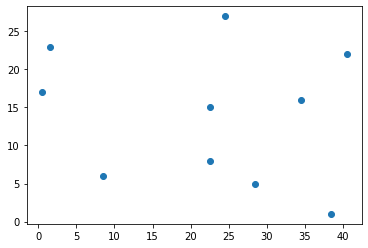

In [8]:
Seed = 42
train_sample = train_data.sample(10, random_state=Seed)
G = G_all.loc[train_sample.index, train_sample.index]
print(train_sample.shape, G.shape)
plt.scatter(train_sample['X'], train_sample['Y'])

X_train = train_sample[['X','Y']].values
y_train = train_sample[['Temp']].values.reshape(-1,1)

## Learning the model

In [9]:
nonStat = NottDuns(N=5, eta=1)
nonStat.fit(X_train, X_train, G.values)

## Greedy algorithm for Near Optimal Sensor Placement!

In [10]:
NN = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = nonStat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='MI')
A_ind_Var, _ = nonStat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='Entropy')
MI = nonStat.MI
Var = nonStat.Var

## Visualizing sensor placements/

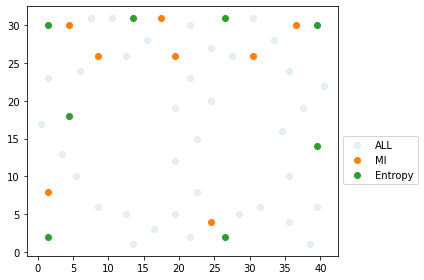

In [12]:
fig, ax = plt.subplots()
iteration = 8
ax.scatter(train_data.X[::-1], train_data.Y[::-1], alpha=0.1, label='ALL')
ax.scatter(train_data.loc[A_ind_MI[:iteration]]['X'][::-1], train_data.loc[A_ind_MI[:iteration]]['Y'][::-1], label='MI')
ax.scatter(train_data.loc[A_ind_Var[:iteration]]['X'][::-1], train_data.loc[A_ind_Var[:iteration]]['Y'][::-1], label='Entropy')
ax.legend(bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()